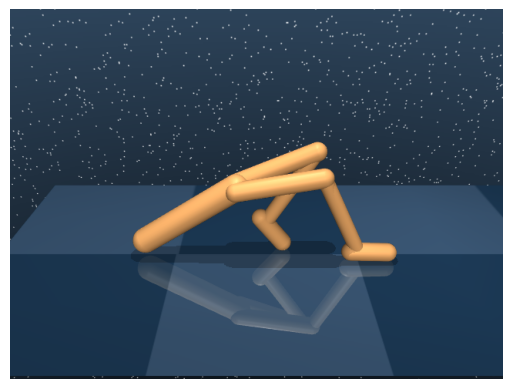

In [1]:
# from mujoco_physics import walkerPhysics
import torch
import os

from mujoco_physics import WalkerPhysics
import torch
import os

output_dir = 'walker_imgs'
os.makedirs(output_dir, exist_ok=True)

#to get the frames saved for vizualization inside hopper_imgs
walker = WalkerPhysics(root='data', download=False, generate=True)

dataset = walker.get_dataset()
traj_index = 1   # Index of the trajectory you want to visualize
trajectory = dataset[traj_index]
walker.visualize(trajectory, plot_name=f'traj_{traj_index}', dirname=output_dir)



## Interactive visualisation with obstacle

In [9]:
from dm_control import suite
from dm_control import viewer
import numpy as np

env = suite.load(domain_name="walker", task_name="walk")
action_spec = env.action_spec()

# Define a uniform random policy.
def random_policy(time_step):
  del time_step  # Unused.
  return np.random.uniform(low=action_spec.minimum,
                           high=action_spec.maximum,
                           size=action_spec.shape)

# Launch the viewer application.
viewer.launch(env, policy=random_policy)

# To change the terain need to change the xml file 
### Add the changes to the terrain : <path>/envs/ece228/lib/python3.12/site-packages/dm_control/suite/walker.xml


## RL implementation : 
### https://colab.research.google.com/drive/19au54XXezRJ7KJU_dLpbc34UHsy3fo7i#scrollTo=g0ktRLLrgCk7